# Решающие деревья, метод ближайших соседей, оценка качества
---
Продолжение истории про переобучение, а ещё исследование и настройка параметров разных методов.

In [11]:
# наша стандартная преамбула
import pandas
import numpy
import matplotlib.pyplot as plt
%matplotlib inline

## Модельные данные

In [12]:
data = numpy.load('data.npz')
X, y = data["X"], data["y"]
X.shape, y.shape

((4505, 2), (4505,))

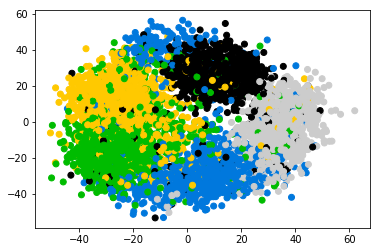

In [13]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='nipy_spectral')

Разделим выборку X на обучающую и тестовую:

In [102]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.75, random_state=153)

Функция для визуализации того, что напредсказывалось:

In [103]:
from sklearn.metrics import accuracy_score

def plot_decision_surface(clf, X, y, plot_step=0.2, cmap='spectral', figsize=(12, 8)):
    # Plot the decision boundary
    plt.figure(figsize=figsize)
    
    n_classes = len(set(y))
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = numpy.meshgrid(numpy.arange(x_min, x_max, plot_step),
                            numpy.arange(y_min, y_max, plot_step))

    Z = clf.predict(numpy.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, alpha=0.5)    
    y_pred = clf.predict(X)

    # Plot the training points
    plt.scatter(*X[y_pred == y].T, marker='.', s=70,
                c=y[y_pred == y], alpha=0.5, label='correct')
    plt.scatter(*X[y_pred != y].T, marker='x', s=50,
                c=y[y_pred != y], label='errors')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.axis("tight")
    plt.legend(loc='best')
    print("Accuracy =", accuracy_score(y, y_pred))

## Здравствуй, дерево
У дерева классификации ([DecisionTreeClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)) есть несколько параметров:
* criterion : как выбирать лучший признак - 'gini' или 'entropy' (по умолчанию gini).
* max_depth :  максимальная глубина дерева (по умолчанию - не ограничено)
* min_samples_split : минимальное количество примеров, которые можно делить дальше (по умолчанию 2)
* min_samples_leaf : минимальное количество примеров в листе (по умолчанию 1).

Сейчас все параметры установлены по умолчанию, но скоро это изменится!

Обучим дерево на train'e:

In [49]:
from sklearn.tree import DecisionTreeClassifier

tree_model = DecisionTreeClassifier(criterion = 'entropy', max_depth = 8, min_samples_split=10, min_samples_leaf=)

tree_model.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=100,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Accuracy = 0.7877442273534636


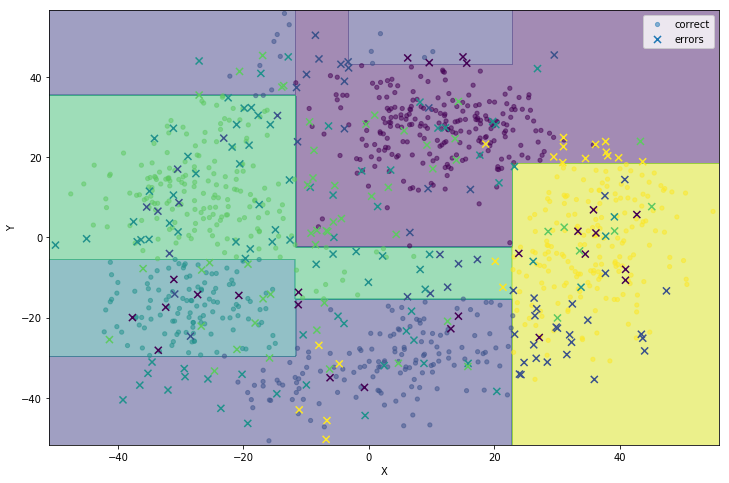

In [50]:
plot_decision_surface(tree_model, X_train, Y_train)

Визуализация на тесте:

Accuracy = 0.7659070730985499


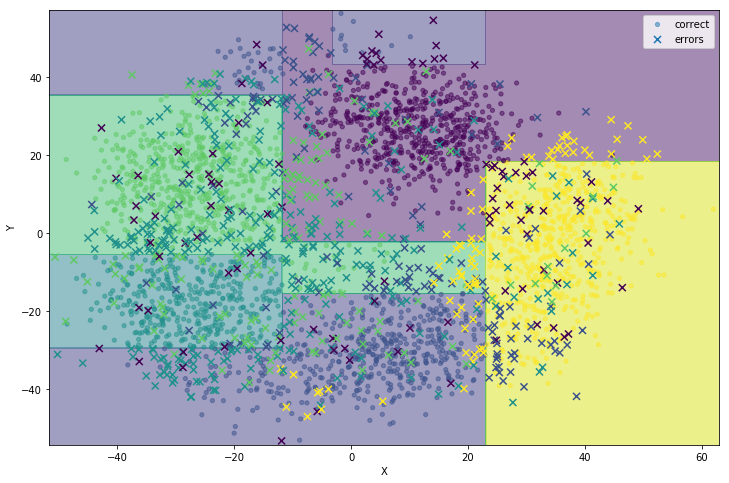

In [51]:
plot_decision_surface(tree_model, X_test, Y_test)

Попробуй подобрать параметры модели так, чтобы улучшить качество.

(можно просто менять код наверху и заново всё выполнять)

---
Дерево классификации строится так, чтобы лучше __подогнаться__ под __обучающую выборку__.
Сейчас вы __подгоняете__ параметры модели так, чтобы качество на __тестовой выборке__ было наибольшим.
По сути, вы больше не можете считать, что качество на тесте - хорошая оценка реального качества, потому что вы подгоняетесь под эту выборку.

Как с этим бороться?

### Классификация зверушек
Датасет содержит информацию о животных (наличие шерсти/перьев/позвоночника...), принадлежащих тому или иному классу (птицы, млекопитающие, рыбы, насекомые...). По набору признаков хотим предсказывать класс животного.

Представленные классы животных:
- 1 -- млекопитающие (41)
- 2 -- птицы (20)
- 3 -- рептилии (5)
- 4 -- рыбы (13)
- 5 -- амфибии (4)
- 6 -- насекомые (8)
- 7 -- беспозвоночные (10)

Ссылки на датасет:

https://www.kaggle.com/uciml/zoo-animal-classification

https://archive.ics.uci.edu/ml/datasets/Zoo

---

#### *Подумать*

- выборка содержит не очень много объектов
- классы несбалансированны

К каким последствиям это приведёт?

In [53]:
zoo_data = pandas.read_csv('zoo.csv')
zoo_data.shape

(101, 18)

In [59]:
zoo_data.head()

,animal_name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1
2,bass,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
3,bear,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
4,boar,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1


Выделим признаковые и целевую переменные:

In [62]:
# class_type -- target, animal_name -- target description
X_zoo = zoo_data.drop(['animal_name', 'class_type'], axis=1)
y_zoo = zoo_data.class_type

Разобьём выборку на обучающую и тестовую:

In [63]:
Xz_train, Xz_test, yz_train, yz_test = train_test_split(X_zoo, y_zoo, test_size=0.6, random_state=153)

При построении дерева классификатор "задаёт вопросы" по выборке. Чем лучше вопрос отделяет друг от друга объекты, тем полезнее признак.
На этом датасете получаются очень логичные наиболее важные признаки (те, которые дают хорошее разбиение объектов). 

Посмотрим на результат обучения при ограничении высоты дерева (== числа вопросов):

In [64]:
tree_model = DecisionTreeClassifier(max_depth=3, random_state=153)

In [66]:
tree_model.fit(Xz_train, yz_train)
yz_pred = tree_model.predict(Xz_test)
print("Train accuracy:", accuracy_score(yz_train, tree_model.predict(Xz_train)))
print("Test accuracy:", accuracy_score(yz_test, yz_pred))

Train accuracy: 0.85
Test accuracy: 0.7868852459016393


In [67]:
feature_importances = tree_model.feature_importances_
feature_names = numpy.array(Xz_train.columns)
print("Наиболее важные признаки:", feature_names[feature_importances > 0])

Наиболее важные признаки: ['feathers' 'milk' 'fins']


Выведи правильные и предсказанные классы объектов, на которых классификатор допускает ошибку.

## Random Forest
Полезные параметры [RandomForestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html):
- n_estimators: количество деревьев в лесу
- criterion: как выбирать лучший признак - 'gini' или 'entropy' (по умолчанию gini)
- max_features: количество признаков при построении дерева (по умолчанию $\sqrt{\text{количество признаков}}$)
- max_depth: максимальная глубина дерева (по умолчанию не ограничено)
- min_samples_split: минимальное количество примеров, которые можно делить дальше (по умолчанию 2)
- min_samples_leaf: минимальное количество примеров в листе (по умолчанию 1).

In [68]:
from sklearn.ensemble import RandomForestClassifier

Вернёмся к рассмотрению модельных данных. Обучи случайный лес на X_train, Y_train:

In [97]:
rf_model = RandomForestClassifier(100, max_depth=30, min_samples_split = 40).fit(X_train, Y_train)

Accuracy = 0.8294849023090586


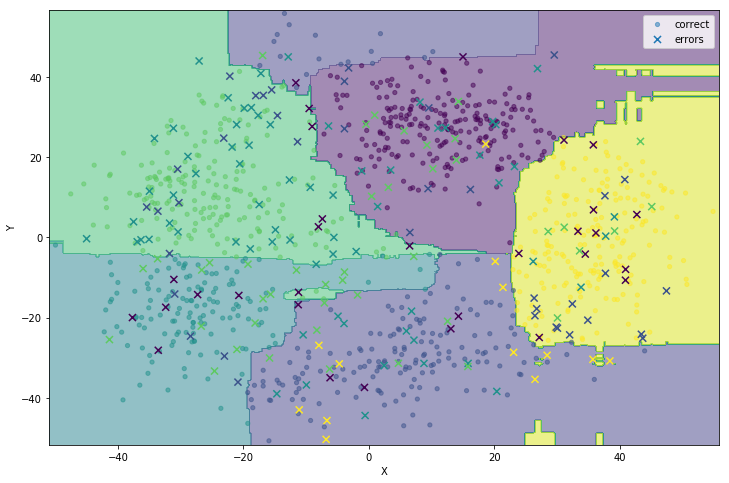

In [98]:
plot_decision_surface(rf_model, X_train, Y_train)

Accuracy = 0.7922462266942882


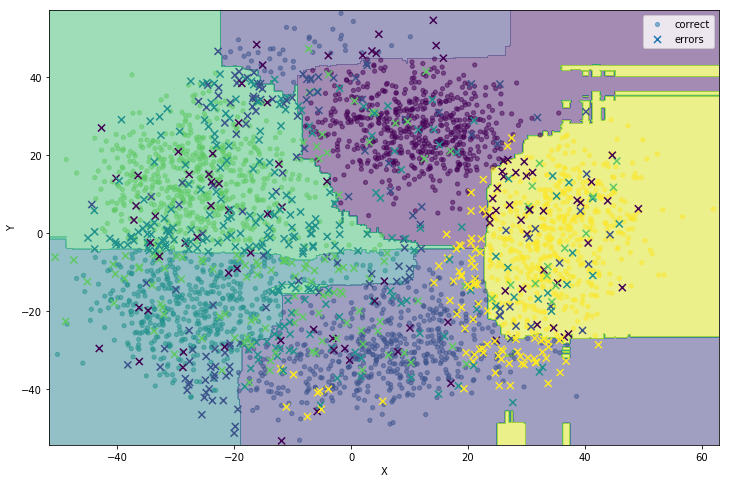

In [99]:
plot_decision_surface(rf_model, X_test, Y_test)

## k nearest neighbors
Основные параметры метода ближайших соседей ([KNeighborsClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)):
- n_neighbors: число соседей (по умолчанию 5)
- metric: способ измерения расстояния между объектами (по умолчанию euclidian -- обычное расстояние из геометрии,
можно выбирать "euclidean", "manhattan", "chebyshev", "haversine")

Пока оставим параметры по умолчанию и обучим модель.

In [100]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier()

knn_model.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

Посмотрим, что получилось на обучающей и тестовой выборке:

Accuracy = 0.8365896980461812


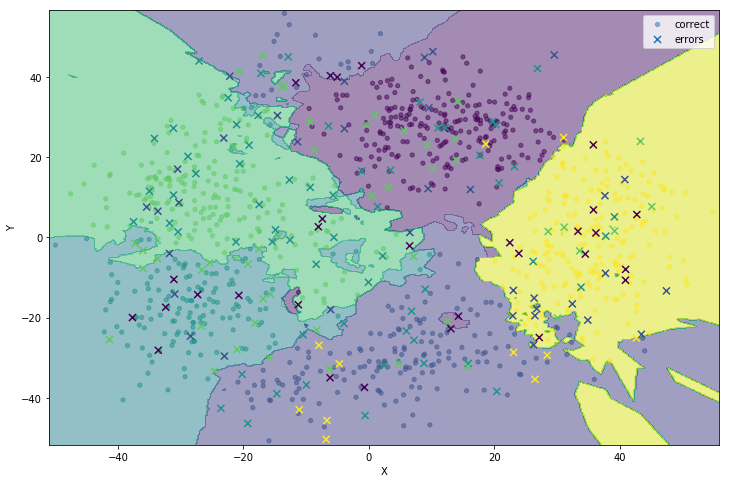

In [101]:
plot_decision_surface(knn_model, X_train, Y_train)

In [ ]:
plot_decision_surface(knn_model, X_test, Y_test)


---
Ответим на вопрос, как же подбирать параметры, чтобы доверять полученным значениям качества на тесте.

Например, можно выделить ещё одну "совсем тестовую" выборку, положить её под камень и не использовать при выборе гиперпараметров -- и оцениваться на ней только 1 раз, когда вы уже определились с моделью.

---

## Кросс-валидация
-- это способ оценивания качества модели, при котором обучение происходит только на некоторой части данных и другая часть всегда сохраняется для проверки полученных предсказаний.
![](https://ndphillips.github.io/UZurich-6April2017/images/crossvalidation.jpg)
Подробнее можно почитать, например, [здесь](http://datascientist.one/cross-validation/).
 
Функция [cross_val_score](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score) принимает на вход классификатор с заданными параметрами и выборку с ответами. 
Параметр cv отвечает за количество разбиений выборки.

На выходе -- список значений score по каждой подвыборке.

In [19]:
from sklearn.model_selection import cross_val_score

Выведи значения cross_val_score для пары-тройки разных значений параметров [решающего дерева](#Здравствуй,-дерево) и [метода ближайших соседей](#k-nearest-neighbors).

Выбери лучшие из них (например те, которые дают налучшее среднее значение score).

In [20]:
#<твой код>

### Grid search

Найдите оптимальные параметры каждого из классификаторов поиском по сетке.

- *Можно написать скрипт, который будет самостоятельно перебирать наборы параметров и выбирать те, у которых в итоге лучше точность.*
- *А можно сделать from sklearn.model_selection import GridSearchCV и научиться с ним работать.*

In [21]:
#<твой код>

final_model = None #<твой код>

In [ ]:
plot_decision_surface(final_model, X_test, Y_test)